# Explore 3D pose estimation on fitness-AQA and opencap datasets

# load preliminaries

In [1]:
import os, sys, glob
import pickle as pkl
from pathlib import Path
import yaml, json
import importlib
import fnmatch
import shutil
import imageio
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# helper functions

In [33]:
def write_directory_structure(dir: Path, out_fname: str):
    with open(dir / out_fname, 'w') as f:
        for root, dirs, files in os.walk(str(dir)):
            level = root.replace(str(dir), '').count(os.sep)
            indent = ' ' * 4 * (level)
            f.write(f'{indent}{os.path.basename(root)}\n')
            subindent = ' ' * 4 * (level + 1)
            for file in files:
                f.write(f'{subindent}{file}\n')

In [99]:
from moviepy.editor import VideoFileClip, clips_array
from collections import defaultdict

def generate_cmd_txt(ds_root_dir: Path, output_dir: Path, script_path_1="scripts/demo_inference.py", script_path_2="infer_wild.py"):
    """Create separate text files for alphapose halpe26 and motionbert commands (overwrites existing)"""
    video_files = list(ds_root_dir.rglob("*.mp4")) # recursive
    with open(output_dir / "halpe26_commands.txt", "w") as halpe26_txt, open(output_dir / "motionbert_commands.txt", "w") as motionbert_txt:
        for video in video_files:
            video_name = video.stem
            halpe26_outdir = video.parent / f"{video_name}_halpe26"
            motionbert_outdir = video.parent / f"{video_name}_motionbert"
            cmd_line_1 = f"python {script_path_1} --cfg configs/halpe_26/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/halpe26_fast_res50_256x192.pth --video {video} --save_video --outdir {halpe26_outdir}\n"
            cmd_line_2 = f"python {script_path_2} --vid_path {video} --json_path {halpe26_outdir / 'alphapose-results.json'} --out_path {motionbert_outdir}\n"
            halpe26_txt.write(cmd_line_1)
            motionbert_txt.write(cmd_line_2)


def create_xpanel_video_cmds(ds_root_dir: Path, output_dir: Path, suffixes, script_rpath="src/visualization/create_xpanel_video.py"):
    """Create a text file with Python commands to create x-panel videos"""
    base_suffix = suffixes[0]  # We will find videos with this suffix first
    other_suffixes = suffixes[1:]
    video_paths_by_suffix = {}

    # Find videos with the base suffix
    base_search_pattern = f"**/*_{base_suffix}/*.mp4"
    print(f"Searching with pattern: {base_search_pattern}")
    video_paths_by_suffix[base_suffix] = list(ds_root_dir.rglob(base_search_pattern))
    print(f"Found {len(base_videos_paths)} base videos")
    for other_suffix in other_suffixes:
        other_search_pattern = f"**/*_{other_suffix}/*.mp4"
        print(f"Searching for matches with pattern: {other_search_pattern}")
        video_paths_by_suffix[other_suffix] = list(ds_root_dir.rglob(other_search_pattern))
        print(f"Found {len(video_paths_by_suffix[other_suffix])} videos with suffix {other_suffix}")

    # For each base video, try to find matching videos with the other suffixes
    matched_base_dirs = []
    for path in video_paths_by_suffix[base_suffix]:
        ct_other_found = 0
        for other_suffix in other_suffixes:
            other_parent_dirs = [str(video.parent.parent) for video in video_paths_by_suffix[other_suffix]]
            if str(path.parent.parent) in other_parent_dirs:
                ct_other_found += 1
        if ct_other_found == len(other_suffixes):
            matched_base_dirs.append(path.parent.parent)
        else:
            print(f"{ct_other_found=}", f"{path=}")

    # Write txt file
    with open(output_dir / "xpanel_commands.txt", "w") as txt_file:
        for dir in matched_base_dirs:
            video_paths = []
            path = str(list(dir.rglob(base_search_pattern))[0])
            video_paths.append(path)
            for other_suffix in other_suffixes:
                path = str(list(dir.rglob(f"**/*_{other_suffix}/*.mp4"))[0])
                video_paths.append(path)

            output_video_dir = str((dir.relative_to(ds_root_dir)).as_posix()).replace('/', '_') # rename based on directory structure
            cmd_line = (
                f"python {script_rpath} --output_video \"{output_dir / f'{output_video_dir}_xpanel.mp4'}\" --video_files {' '.join(video_paths)}\n"
            )
            txt_file.write(cmd_line)

    return video_paths_by_suffix


# Run commands for Fitness-AQA dataset

In [34]:
# windows path
AQA_ROOT_DIR = Path(r"C:\MLprojects\human_motion_analysis\data\Fitness-AQA\Fitness-AQA_dataset_release_001\Squat\Labeled_Dataset\videos_pilot")

write_directory_structure(AQA_ROOT_DIR, "dir_struct.txt")
generate_cmd_txt(AQA_ROOT_DIR.resolve(), AQA_ROOT_DIR.resolve()) # absolute path
create_2panel_video_cmds(AQA_ROOT_DIR.resolve(), AQA_ROOT_DIR.resolve()) # absolute path

# Run commands for opencap dataset

In [48]:
OCAP_ROOT_DIR = Path(r"C:\MLprojects\human_motion_analysis\data\opencap")
generate_cmd_txt(OCAP_ROOT_DIR.resolve(), OCAP_ROOT_DIR.resolve()) # absolute path

In [267]:
suffixes = ["halpe26", "motionbert"]
create_xpanel_video_cmds(OCAP_ROOT_DIR.resolve(), OCAP_ROOT_DIR.resolve(), suffixes) # absolute path

Searching with pattern: **/*_halpe26/*.mp4
Found 525 base videos
Searching for matches with pattern: **/*_motionbert/*.mp4
Found 837 videos with suffix motionbert


{'halpe26': [WindowsPath('C:/MLprojects/human_motion_analysis/data/opencap/LabValidation_withVideos/subject10/VideoData/Session0/Cam0/DJ1/DJ1_synced_halpe26/AlphaPose_DJ1_synced.mp4'),
  WindowsPath('C:/MLprojects/human_motion_analysis/data/opencap/LabValidation_withVideos/subject10/VideoData/Session0/Cam0/DJ2/DJ2_synced_halpe26/AlphaPose_DJ2_synced.mp4'),
  WindowsPath('C:/MLprojects/human_motion_analysis/data/opencap/LabValidation_withVideos/subject10/VideoData/Session0/Cam0/DJ3/DJ3_synced_halpe26/AlphaPose_DJ3_synced.mp4'),
  WindowsPath('C:/MLprojects/human_motion_analysis/data/opencap/LabValidation_withVideos/subject10/VideoData/Session0/Cam0/DJAsym1/DJAsym1_synced_halpe26/AlphaPose_DJAsym1_synced.mp4'),
  WindowsPath('C:/MLprojects/human_motion_analysis/data/opencap/LabValidation_withVideos/subject10/VideoData/Session0/Cam0/DJAsym2/DJAsym2_synced_halpe26/AlphaPose_DJAsym2_synced.mp4'),
  WindowsPath('C:/MLprojects/human_motion_analysis/data/opencap/LabValidation_withVideos/subjec

In [ ]:
write_directory_structure(OCAP_ROOT_DIR, "dir_struct_after_alphapose_motionbert.txt")

# Plot 3D Pose Estimation results

In [343]:
x3d_paths = list(OCAP_ROOT_DIR.rglob("**/x3d.npy"))
len(x3d_paths)

837

In [230]:
COCO_KPTS = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}

In [344]:
def plot_keypoints(paths: list[Path], savefig_dir: Path, savefigTF=False, legend=COCO_KPTS.keys()):
    savefig_dir.mkdir(exist_ok=True)
    for path in paths:
        keypoints = np.load(path) # e.g. (356, 17, 3)
        title_from_path = path.relative_to(OCAP_ROOT_DIR).as_posix().replace('/', '_')
        fig, ax = plt.subplots(3, 1, figsize=(12, 6))
        for ai, axis in enumerate(["X", "Y", "Z"]):
            ax[ai].plot(keypoints[:, :, ai])
            ax[ai].set_title(f"{axis} axis", fontsize=14)
        plt.legend(legend, bbox_to_anchor=(1.05, 1), loc="lower left")
        plt.suptitle(title_from_path, fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.5)
        if savefigTF:
            plt.savefig(f"{str(savefig_dir.joinpath(title_from_path))}.png", dpi=300, bbox_inches="tight")
            plt.close()

(array([5.500000e+01, 2.300000e+02, 1.323000e+03, 6.247000e+04,
        4.169500e+04, 3.411300e+04, 4.979200e+04, 8.471600e+04,
        7.586700e+04, 1.113090e+05, 1.434130e+05, 1.676780e+05,
        2.349770e+05, 1.698990e+05, 1.926970e+05, 2.248550e+05,
        2.739800e+05, 4.221180e+05, 6.280110e+05, 8.247080e+05,
        9.713020e+05, 1.043342e+06, 1.179187e+06, 1.172324e+06,
        1.167866e+06, 1.557388e+06, 1.002801e+06, 1.031212e+06,
        8.522830e+05, 7.497830e+05, 5.628010e+05, 4.660750e+05,
        3.451200e+05, 2.606880e+05, 2.265720e+05, 2.374710e+05,
        2.186700e+05, 1.384610e+05, 9.198000e+04, 6.405800e+04,
        4.944700e+04, 4.476400e+04, 7.081200e+04, 1.076260e+05,
        7.932100e+04, 2.406900e+05, 4.543300e+04, 1.859000e+03,
        1.540000e+02, 2.200000e+01]),
 array([-1.17253292, -1.12605238, -1.07957184, -1.03309131, -0.98661077,
        -0.94013029, -0.89364976, -0.84716922, -0.80068868, -0.75420815,
        -0.70772761, -0.66124707, -0.61476654, -

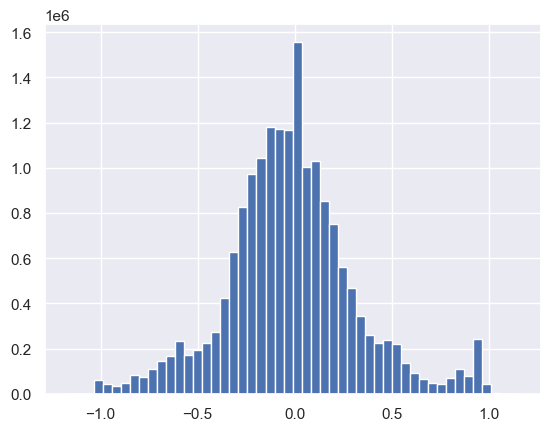

In [345]:
kpts_all = []
for path in x3d_paths:
    keypoints = np.load(path) # e.g. (356, 17, 3)
    kpts_all.append(keypoints)

plt.hist(np.vstack(kpts_all).reshape(-1), bins=50)

(0.0, 6000.0)

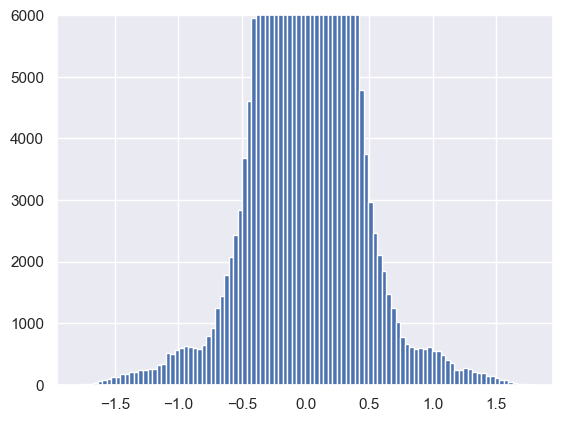

In [346]:
# get velocities
velocities = []
for path in x3d_paths:
    keypoints = np.load(path) # e.g. (356, 17, 3)
    velocities.append(np.diff(keypoints, axis=0))

velocities_all_flat = np.vstack(velocities).reshape(-1)

plt.hist(velocities_all_flat, bins=100)
plt.ylim(0, 6000)

(0.0, 0.002)

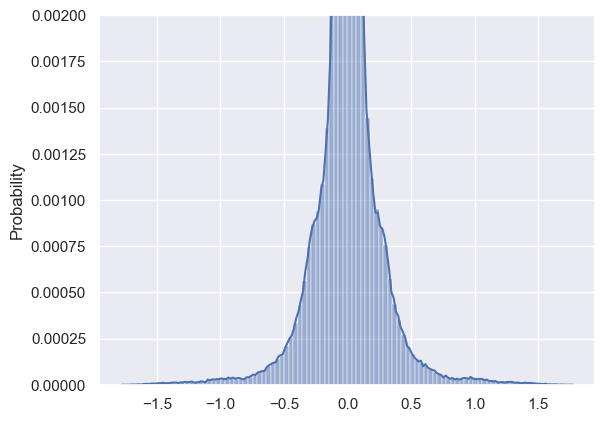

In [347]:
sns.histplot(velocities_all_flat, bins=100, stat="probability", kde=True)
plt.ylim(0, 0.002)

In [348]:
print(f"length of all all velocities datapoints: {len(velocities_all_flat)}")
print(f"length of all velocities datapoints > 0.5: {len(velocities_all_flat[velocities_all_flat > 0.5])} | percentage = {len(velocities_all_flat[velocities_all_flat > 0.5])/len(velocities_all_flat)}")
print(f"length of all velocities datapoints < -0.5: {len(velocities_all_flat[velocities_all_flat < -0.5])} | percentage = {len(velocities_all_flat[velocities_all_flat < -0.5])/len(velocities_all_flat)}")

length of all all velocities datapoints: 17680731
length of all velocities datapoints > 0.5: 21602 | percentage = 0.001221782063196369
length of all velocities datapoints < -0.5: 21629 | percentage = 0.0012233091493784958


## separate good videos vs. those with anomalies based on kde thresholding

In [355]:
# determined threshold as below visually and with kde
contains_outliers = np.zeros(len(velocities), dtype=bool)
for i, v in enumerate(velocities):
    contains_outliers[i] = np.logical_or(v > 0.2, v < -0.2).any()

print("Total number of videos processed:", len(contains_outliers))
print("Number of videos with anomalies:", np.sum(contains_outliers))

indices = np.where(contains_outliers)[0]

x3d_paths_anomalies_subset = [x3d_paths[i] for i in indices]
x3d_paths_good_subset = [x3d_paths[i] for i in np.where(~contains_outliers)[0]]
print(f"------anomalies subset------{len(x3d_paths_anomalies_subset)=}")
print('\n'.join([str(p) for p in x3d_paths_anomalies_subset]))
print(f"------good subset------{len(x3d_paths_good_subset)=}")
print('\n'.join([str(p) for p in x3d_paths_good_subset]))

Total number of videos processed: 837
Number of videos with anomalies: 196
------anomalies subset------len(x3d_paths_anomalies_subset)=196
C:\MLprojects\human_motion_analysis\data\opencap\LabValidation_withVideos\subject10\VideoData\Session0\Cam0\DJ1\DJ1_synced_motionbert\x3d.npy
C:\MLprojects\human_motion_analysis\data\opencap\LabValidation_withVideos\subject10\VideoData\Session0\Cam0\DJ2\DJ2_synced_motionbert\x3d.npy
C:\MLprojects\human_motion_analysis\data\opencap\LabValidation_withVideos\subject10\VideoData\Session0\Cam0\DJ3\DJ3_synced_motionbert\x3d.npy
C:\MLprojects\human_motion_analysis\data\opencap\LabValidation_withVideos\subject10\VideoData\Session0\Cam0\DJAsym1\DJAsym1_synced_motionbert\x3d.npy
C:\MLprojects\human_motion_analysis\data\opencap\LabValidation_withVideos\subject10\VideoData\Session0\Cam0\DJAsym2\DJAsym2_synced_motionbert\x3d.npy
C:\MLprojects\human_motion_analysis\data\opencap\LabValidation_withVideos\subject10\VideoData\Session0\Cam0\DJAsym3\DJAsym3_synced_moti

In [356]:
savefig_dir = OCAP_ROOT_DIR / "motionbert_plots_good_filtered"
plot_keypoints(x3d_paths_good_subset, savefig_dir, savefigTF=True) # approx 10 min for 600 videos

# Test classifiers

## make labels from paths

In [358]:
import re
activity_names = []

for path in x3d_paths_good_subset:

    match = re.search(r'\\([^\\]+)_synced_motionbert', str(path))
    if match:
        activity_name = re.sub(r'\d+$', '', match.group(1))
        activity_names.append(activity_name)

print(activity_names)

['static', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'squats', 'squatsAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'static', 'STSweakLegs', 'DJ', 'DJ', 'DJAsym', 'squatsAsym', 'STS', 'walking', 'walking', 'walking', 'walkingTS', 'walkingTS', 'walkingTS', 'walking', 'walking', 'walking', 'walkingTS', 'walkingTS', 'walkingTS', 'walking', 'walking', 'walking', 'walkingTS', 'walkingTS', 'walking', 'walking', 'walking', 'walkingTS', 'walkingTS', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'squats', 'squatsAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'squats', 'squatsAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'squats', 'squatsAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'sq

In [373]:
unique_labels = set(activity_names)
labels = np.array(activity_names)
labels

array(['static', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'squats',
       'squatsAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ',
       'DJAsym', 'DJAsym', 'DJAsym', 'static', 'STS', 'STSweakLegs', 'DJ',
       'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'static', 'STSweakLegs',
       'DJ', 'DJ', 'DJAsym', 'squatsAsym', 'STS', 'walking', 'walking',
       'walking', 'walkingTS', 'walkingTS', 'walkingTS', 'walking',
       'walking', 'walking', 'walkingTS', 'walkingTS', 'walkingTS',
       'walking', 'walking', 'walking', 'walkingTS', 'walkingTS',
       'walking', 'walking', 'walking', 'walkingTS', 'walkingTS', 'DJ',
       'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'static', 'STS', 'STSweakLegs',
       'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym', 'DJAsym', 'squats',
       'squatsAsym', 'static', 'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ',
       'DJAsym', 'DJAsym', 'DJAsym', 'squats', 'squatsAsym', 'static',
       'STS', 'STSweakLegs', 'DJ', 'DJ', 'DJ', 'DJAsym', 'DJAsym',
       'DJ

## make features

In [365]:
kpts_good = []
for path in x3d_paths_good_subset:
    keypoints = np.load(path) # e.g. (356, 17, 3)
    kpts_good.append(keypoints)

AttributeError: 'list' object has no attribute 'toarray'

In [367]:
kpts_good[0].shape

(135, 17, 3)

## make simple MLP model

In [368]:
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# # Assuming kpts_good is a list of videos with shape (frames, keypoints, coordinates)
# # Assuming labels is a list of corresponding labels

# # Convert kpts_good and labels to tensors
# feature_set = torch.tensor(kpts_good, dtype=torch.float32)
# activity_labels = torch.tensor(labels, dtype=torch.long)

# # Define a custom dataset
# class ActivityDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = features
#         self.labels = labels

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, index):
#         feature = self.features[index]
#         label = self.labels[index]
#         return feature, label

# # Specify the input size, hidden size, and number of classes
# input_size = feature_set[0].shape[1] * feature_set[0].shape[2]  # keypoints * coordinates
# hidden_size = 100
# num_classes = 9

# # Create an instance of the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu1(out)
#         out = self.fc2(out)
#         out = self.relu2(out)
#         out = self.fc3(out)
#         return out

# model = MLP(input_size, hidden_size, num_classes)

# # Create an instance of the custom dataset
# dataset = ActivityDataset(feature_set, activity_labels)

# # Create a data loader for batching the dataset
# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# num_epochs = 10
# for epoch in range(num_epochs):
#     for features, labels in dataloader:
#         # Flatten the input features
#         features = features.view(features.size(0), -1)

#         # Forward pass
#         outputs = model(features)

#         # Compute the loss
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Print the loss for every epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# # Example inference
# test_input = feature_set[0].view(1, -1)  # Take the first video as a test input and flatten it
# predicted_scores = model(test_input)
# predicted_labels = torch.argmax(predicted_scores, dim=1)
# print("Predicted Labels:", predicted_labels)


ModuleNotFoundError: No module named 'torch'

In [376]:
# get lengths and get minimum length
lengths = []
for path in x3d_paths_good_subset:
    keypoints = np.load(path) # e.g. (356, 17, 3)
    lengths.append(keypoints.shape[0])

min_length = min(lengths)
print(f"min length: {min_length}")

min length: 58


In [432]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers

# Assuming kpts_good is a list of videos with shape (frames, keypoints, coordinates)
# Assuming labels is a list of corresponding labels

# Convert kpts_good to a list of TensorFlow tensors
feature_set = [tf.convert_to_tensor(arr[:50, :, :].reshape(50, -1), dtype=tf.float32) for arr in kpts_good]

# Perform label encoding on the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_set, encoded_labels, test_size=0.2, random_state=42)

# Convert the training feature set and labels to TensorFlow tensors
X_train_tensor = tf.stack(X_train)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)

# Define the MLP model
mlp_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(X_train_tensor.shape[1], X_train_tensor.shape[2])),
    layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
mlp_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
mlp_model.fit(X_train_tensor, y_train_tensor, epochs=100, batch_size=64)

# Evaluate the model on the test set
X_test_tensor = tf.stack(X_test)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)
_, test_accuracy = mlp_model.evaluate(X_test_tensor, y_test_tensor)

print("Test Accuracy:", test_accuracy)

# Perform inference on the test set
predicted_scores = mlp_model.predict(X_test_tensor)
predicted_labels = tf.argmax(predicted_scores, axis=1).numpy()


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 1.7232 - accuracy: 0.3066
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 1.2853 - accuracy: 0.4629
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 1.0290 - accuracy: 0.4941
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.9331 - accuracy: 0.5098
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.8917 - accuracy: 0.4941
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.8236 - accuracy: 0.5527
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 0.9150 - accuracy: 0.5234
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 0.8457 - accuracy: 0.5625
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.8034 - accuracy: 0.5430
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 0.7505 - accuracy: 0.5332
Epoch 11/100
8/8 [===========

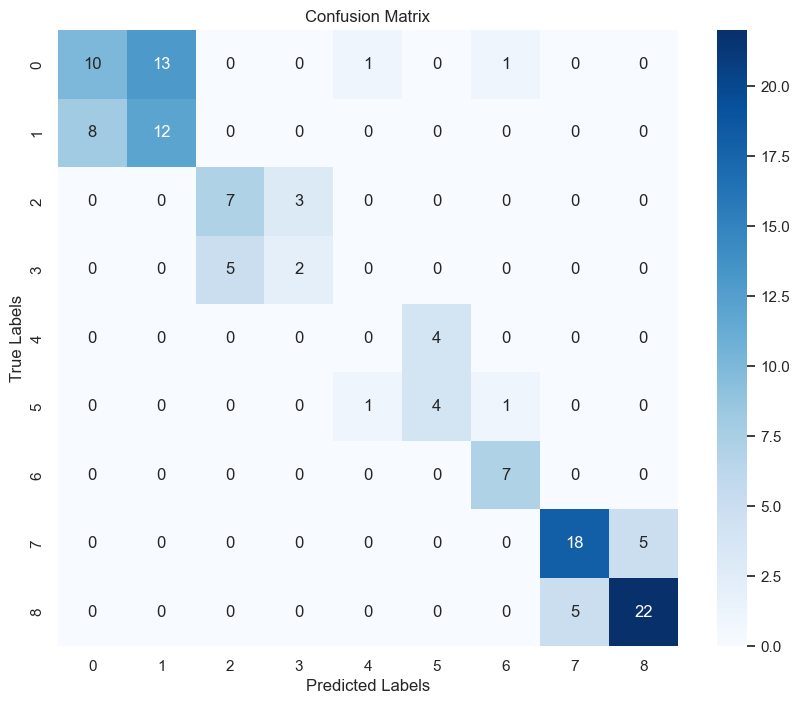

In [433]:
confusion_mlp = confusion_matrix(decoded_truth_labels, decoded_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [384]:
label_encoder.classes_

array(['DJ', 'DJAsym', 'STS', 'STSweakLegs', 'squats', 'squatsAsym',
       'static', 'walking', 'walkingTS'], dtype='<U11')

Epoch 1/100
8/8 [==============================] - 0s 13ms/step - loss: 2.0336 - accuracy: 0.1777
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1.6682 - accuracy: 0.2676
Epoch 3/100
8/8 [==============================] - 1s 121ms/step - loss: 1.3227 - accuracy: 0.3926
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0088 - accuracy: 0.4551
Epoch 5/100
8/8 [==============================] - 1s 25ms/step - loss: 0.8915 - accuracy: 0.4434
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 0.8321 - accuracy: 0.5117
Epoch 7/100
8/8 [==============================] - 1s 106ms/step - loss: 0.8325 - accuracy: 0.4902
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.8351 - accuracy: 0.4629
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.7589 - accuracy: 0.5586
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 0.7435 - accuracy: 0.5215
Epoch 11/100
8/8 [==

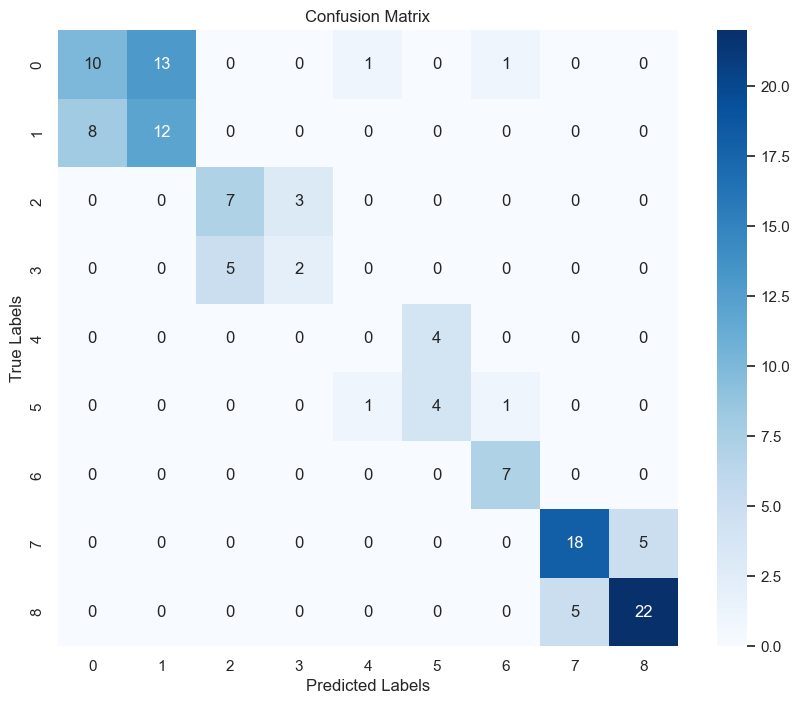

In [434]:
# Define the CNN model
cnn_model = tf.keras.Sequential([
    layers.Reshape((X_train_tensor.shape[1], X_train_tensor.shape[2], 1), input_shape=(X_train_tensor.shape[1], X_train_tensor.shape[2])),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])


# Compile the model
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_tensor, y_train_tensor, epochs=100, batch_size=64)

# Evaluate the model on the test set
X_test_tensor = tf.stack(X_test)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)
_, test_accuracy = cnn_model.evaluate(X_test_tensor, y_test_tensor)

print("Test Accuracy:", test_accuracy)

# Perform inference on the test set
predicted_scores = cnn_model.predict(X_test_tensor)
predicted_labels = tf.argmax(predicted_scores, axis=1).numpy()

confusion_mlp = confusion_matrix(decoded_truth_labels, decoded_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/100
8/8 [==============================] - 1s 7ms/step - loss: 2.0103 - accuracy: 0.2363
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1.3677 - accuracy: 0.4180
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 1.1649 - accuracy: 0.4102
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 1.0362 - accuracy: 0.4668
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9793 - accuracy: 0.4863
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9626 - accuracy: 0.4688
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.8748 - accuracy: 0.5371
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.8414 - accuracy: 0.5215
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.8325 - accuracy: 0.5156
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7845 - accuracy: 0.5176
Epoch 11/100
8/8 [=========

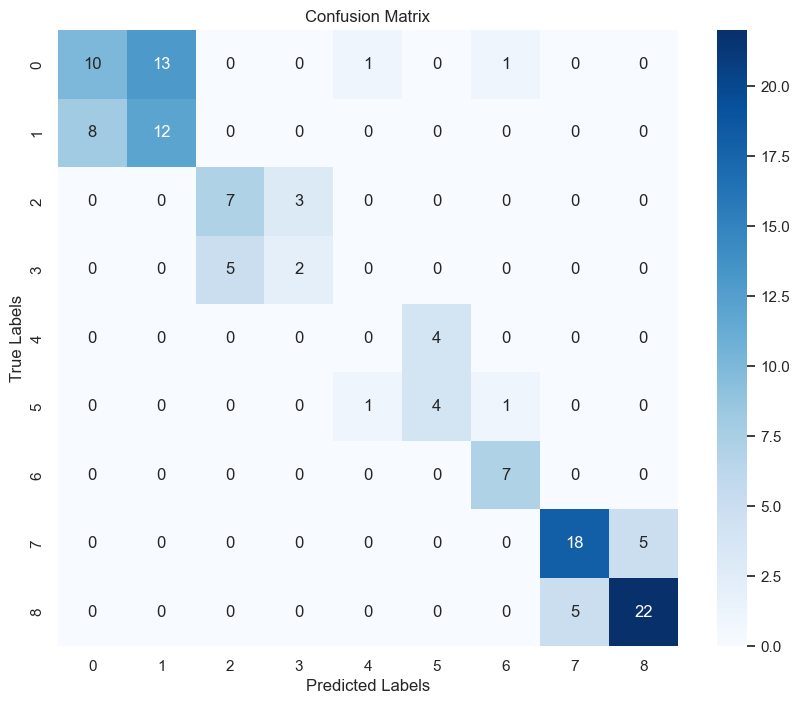

In [435]:
# Define the LSTM model
lstm_model = tf.keras.Sequential([
    layers.LSTM(64, input_shape=(X_train_tensor.shape[1], X_train_tensor.shape[2])),
    layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_tensor, y_train_tensor, epochs=100, batch_size=64)

# Evaluate the model on the test set
X_test_tensor = tf.stack(X_test)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)
_, test_accuracy = lstm_model.evaluate(X_test_tensor, y_test_tensor)

print("Test Accuracy:", test_accuracy)

# Perform inference on the test set
predicted_scores = lstm_model.predict(X_test_tensor)
predicted_labels = tf.argmax(predicted_scores, axis=1).numpy()

confusion_mlp = confusion_matrix(decoded_truth_labels, decoded_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Test PCA

In [428]:
import tensorflow as tf
from sklearn.decomposition import PCA

# Perform PCA on each video in the training feature set
X_train_pca = []
for video in X_train_tensor:
    video_reshaped = video.numpy().reshape(video.shape[0], -1)
    if video_reshaped.shape[0] < 50:
        video_reshaped_padded = np.pad(video_reshaped, ((0, 50 - video_reshaped.shape[0]), (0, 0)), mode='constant')
        video_pca = pca.fit_transform(video_reshaped_padded)
    else:
        video_reshaped_truncated = video_reshaped[:50, :]
        video_pca = pca.fit_transform(video_reshaped_truncated)
    X_train_pca.append(video_pca)

# Convert the PCA features to a TensorFlow tensor
X_train_pca = tf.ragged.constant(X_train_pca)

# Create a tf.data.Dataset from the PCA features and labels
dataset = tf.data.Dataset.from_tensor_slices((X_train_pca, y_train_tensor))

# Define the MLP model with PCA
mlp_model_pca = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train_pca.shape[2],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
mlp_model_pca.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# Convert the dataset to batches and train the model
batch_size = 32
dataset = dataset.batch(batch_size)
mlp_model_pca.fit(dataset, epochs=10)


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Example 3D pose coordinate data
pose_data = np.random.randn(200, 15, 3) * 0.1  # Generate random 3D pose data (200 frames, 15 joints, 3 coordinates)

# Reshape the data for PCA
num_frames, num_joints, num_coords = pose_data.shape
pose_data_reshaped = pose_data.reshape(num_frames, num_joints * num_coords)

# Perform PCA
pca = PCA(n_components=3)  # Choose the number of principal components to keep (here, 3)
pose_data_pca = pca.fit_transform(pose_data_reshaped)

# Reshape the PCA results back to the original joint coordinate structure
pose_data_pca_reshaped = pose_data_pca.reshape(num_frames, num_joints, pca.n_components_)

# Plotting raw 3D pose trajectories
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for frame in range(num_frames):
    ax.plot(pose_data[frame, :, 0], pose_data[frame, :, 1], pose_data[frame, :, 2], alpha=0.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Raw 3D Pose Trajectories')
plt.show()

# Plotting PC trajectories
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for joint in range(num_joints):
    ax.plot(pose_data_pca_reshaped[:, joint, 0], pose_data_pca_reshaped[:, joint, 1], pose_data_pca_reshaped[:, joint, 2], alpha=0.2)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('PC Trajectories')
plt.show()


ValueError: cannot reshape array of size 600 into shape (200,15,3)